In [50]:
import pandas as pd
from plotnine import ggplot, aes, geom_boxplot, geom_point, labs, theme_minimal, facet_wrap, geom_line, geom_bar, theme, element_text
import numpy as np

df = pd.read_csv('avocado-updated-2020.csv')
#df.head()

1. Briefly describe the data set. What information does it contain?
This dataset provides information about avocado sales between 2015 and 2020 in different areas. The geography for the data includes total US, different regions in the US, different states in the US, and different cities in the US. We are able to see the different sales volume for each of these geographies and the date it was recorded, as well as the average price, avocado type, bag size, and avocado size.

In [41]:
df = pd.read_csv('avocado-updated-2020.csv')

avocados_clean = df.dropna()

#print(avocados_clean['geography'].unique())

avocados_clean.rename(columns={
    '4046': 'small_avocado',
    '4225': 'large_avocado',
    '4770': 'extra_large_avocado'
}, inplace=True)

# Used ChatGPT to help with categorizing each geography into country, region, state or metro
def classify_region(x):
    if x == "Total U.S.":
        return 'Country'
    elif x in ["Midsouth", "Northeast", "Great Lakes", "California", "Plains", "South Central", "Southeast", "West"]: #According to the dataset, these are the regions
        return 'Region'
    elif x in ["South Carolina", "West Tex/New Mexico"]:
        return 'State'
    else:
        return 'Metro'
avocados_clean['geography_type'] = avocados_clean['geography'].apply(classify_region)


#avocados_clean

3. Which major geographical region sold the most total organic, small Hass avocados in 2017?

In [42]:
highest_region = avocados_clean[
    (avocados_clean['type'] == 'organic') &
    (avocados_clean['year'] == 2017) &
    (avocados_clean['geography_type'] == "Region")
].groupby('geography')['small_avocado'].sum().idxmax() #Asked ChatGPT for help mapping it back to the geography column

print(highest_region)


West


4. Split the date variable into month, day, and year variables. In which month is the highest average volume of avocado sales?
May has the highest average volume of avocado sales.

In [43]:
avocados_clean['date'] = pd.to_datetime(avocados_clean['date'])
avocados_clean['year'] = avocados_clean['date'].dt.year
avocados_clean['month'] = avocados_clean['date'].dt.month
avocados_clean['day'] = avocados_clean['date'].dt.day #chatGPT gave me the dt.day etc. functions

avocados_clean

highest_avg_month = avocados_clean.groupby('month')['total_volume'].mean().idxmax()
print(highest_avg_month)


5


5. Which metro area geographical regions sold the most total avocados? Plot side-by-side box-plots of the total volume for only the five metro geographical regions with the highest averages for the total_volume variable.

We see that LA, New York, Dallas/Ft. Worth, Houston, and Phoenix/Tuscon sold the most total avocados.

In [26]:
metro_highest_volume = avocados_clean[avocados_clean['geography_type'] == 'Metro'].groupby('geography')['total_volume'].sum().nlargest(5) #ChatGPT suggested nlargest function


print(metro_highest_volume)

geography
Los Angeles         9.593505e+08
New York            5.282452e+08
Dallas/Ft. Worth    4.362042e+08
Houston             4.208438e+08
Phoenix/Tucson      3.825234e+08
Name: total_volume, dtype: float64


Now we will use averages to find the top 5 in average total volume in metro geographical regions. The top 5 in average is the exact same as above.

In [27]:
metro_highest_avg_volume = avocados_clean[avocados_clean['geography_type'] == 'Metro'].groupby('geography')['total_volume'].mean().nlargest(5) #ChatGPT suggested nlargest function


print(metro_highest_avg_volume)

geography
Los Angeles         1.567566e+06
New York            8.631458e+05
Dallas/Ft. Worth    7.127519e+05
Houston             6.876533e+05
Phoenix/Tucson      6.250383e+05
Name: total_volume, dtype: float64


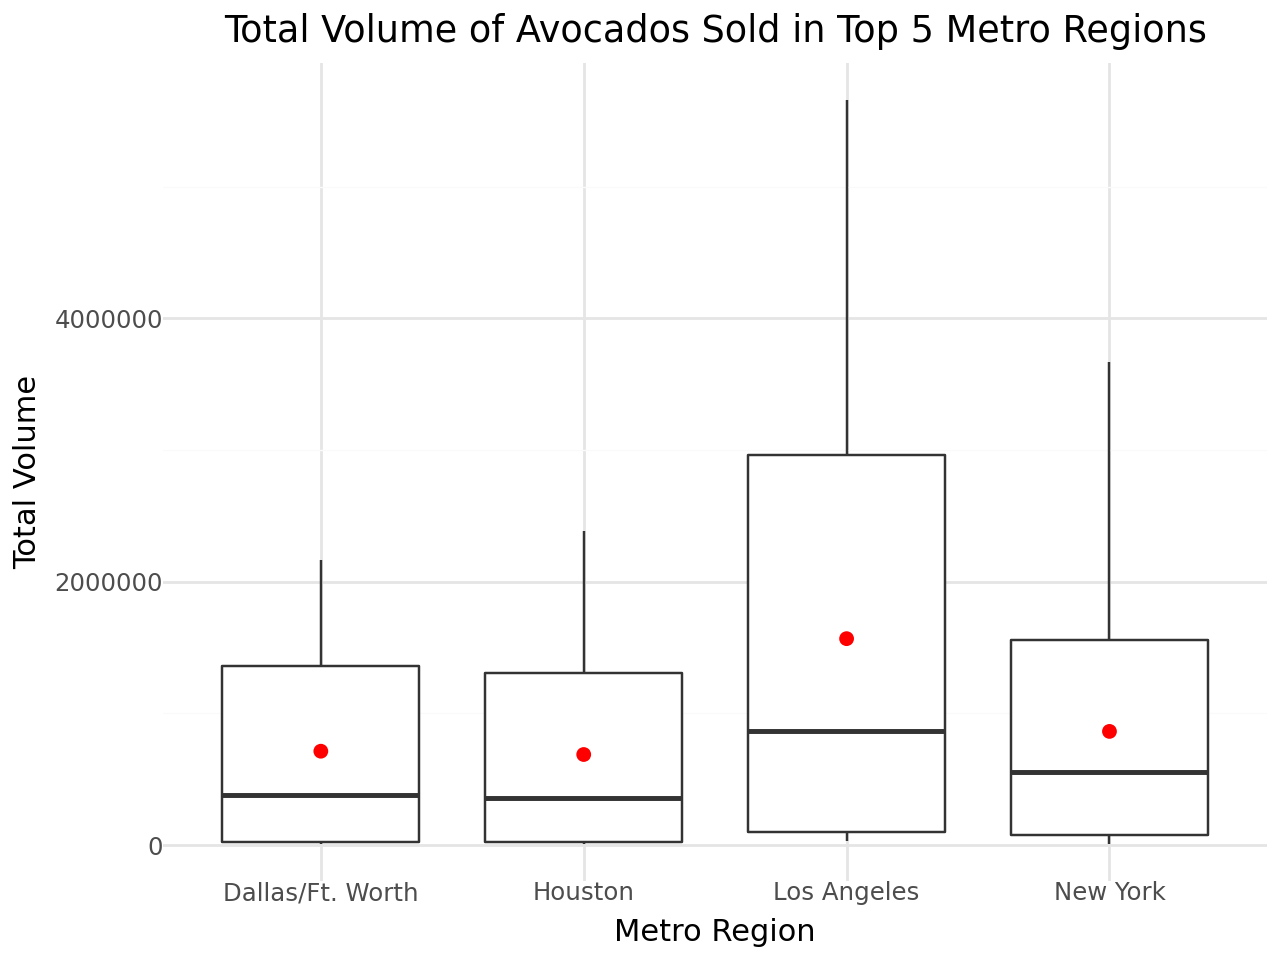

In [28]:
top_5_metro_data = avocados_clean[avocados_clean['geography'].isin(['Los Angeles', 'New York', 'Dallas/Ft. Worth', 'Houston', 'Phoenix/Tuscon'])]

p = (ggplot(top_5_metro_data, aes(x='geography', y='total_volume'))
     + geom_boxplot()
     + geom_point(top_5_metro_data.groupby('geography')['total_volume'].mean().reset_index(), #ChatGPT reccomended to reset index for plotting
                  aes(x='geography', y='total_volume'), color='red', size=2)
     + labs(title='Total Volume of Avocados Sold in Top 5 Metro Regions',
            x='Metro Region',
            y='Total Volume')
     + theme_minimal()
    )
p

7. In which California regions is the price of organic versus conventional avocados most different? Support your answer with a few summary statistics AND a visualization.

We can see the difference in prices for San Francisco is the highest: .719. The ratio between organic prices and conventional prices is highest in San Diego. So we can tell that the pure difference in price is highest in San Francisco since its prices are both higher than the other regions, but the highest ratio is in San Diego.

type            organic  conventional  price_difference     ratio
geography                                                        
Los Angeles    1.574902      1.047124          0.527778  1.504026
Sacramento     1.873856      1.295359          0.578497  1.446592
San Diego      1.798366      1.113856          0.684510  1.614541
San Francisco  2.119444      1.400490          0.718954  1.513359


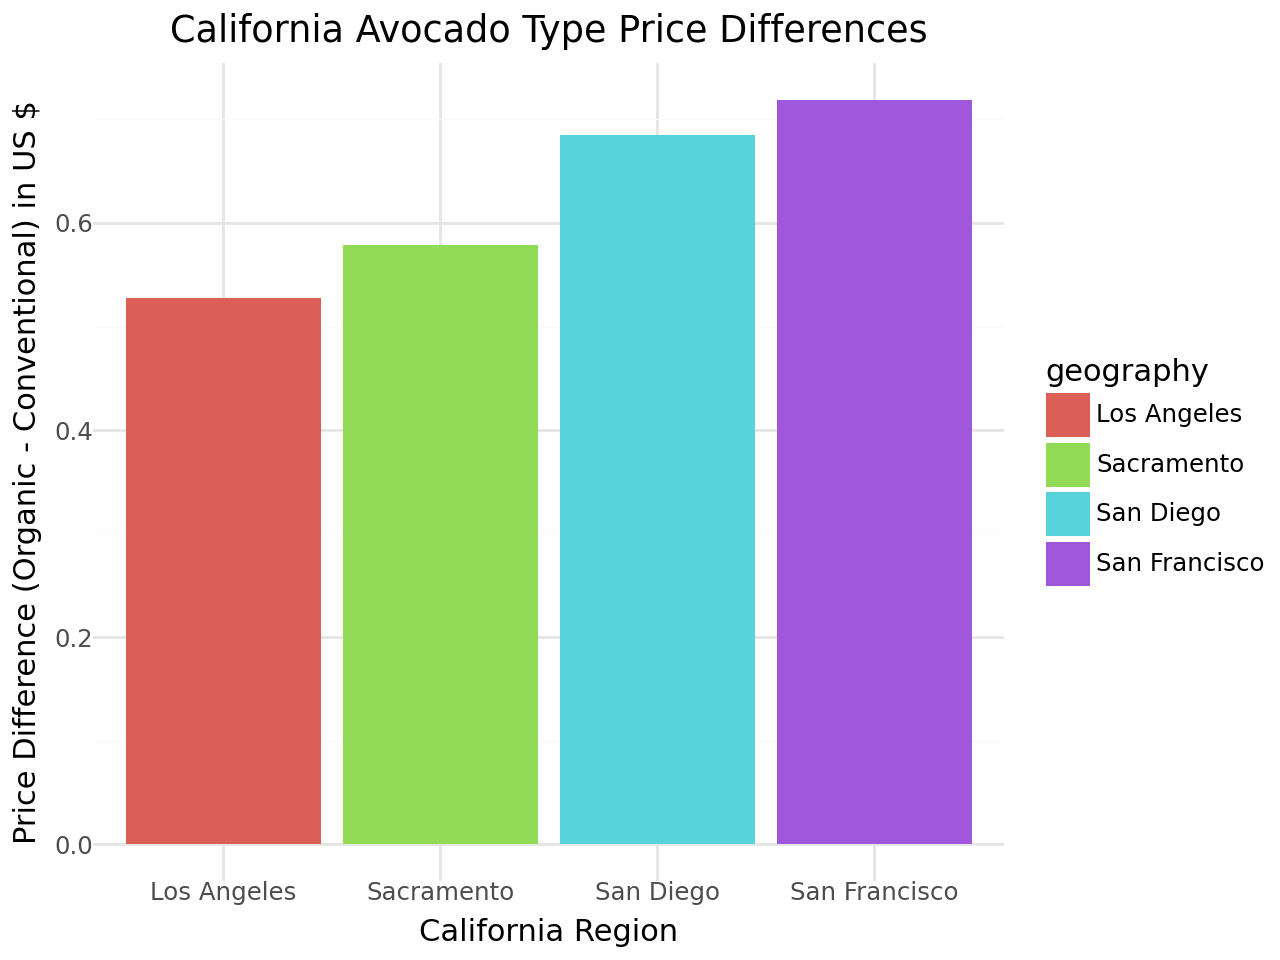

In [29]:
CA_regions = ['Los Angeles', 'San Diego', 'Sacramento', 'San Francisco']
CA_data = avocados_clean[avocados_clean['geography'].isin(CA_regions)]

prices_by_type = CA_data.groupby(['geography', 'type'])['average_price'].mean()
price_diff_table = prices_by_type.unstack()

price_diff_table['price_difference'] = price_diff_table['organic'] - price_diff_table['conventional']
price_diff_table['ratio'] = price_diff_table['organic'] / price_diff_table['conventional']
print(price_diff_table[['organic', 'conventional', 'price_difference', 'ratio']])

price_diff_table = price_diff_table.reset_index()

ggplot(price_diff_table, aes(x='geography', y='price_difference', fill='geography')) \
    + geom_bar(stat='identity') \
    + labs(title='California Avocado Type Price Differences',
           x='California Region',
           y='Price Difference (Organic - Conventional) in US $') \
    + theme_minimal()



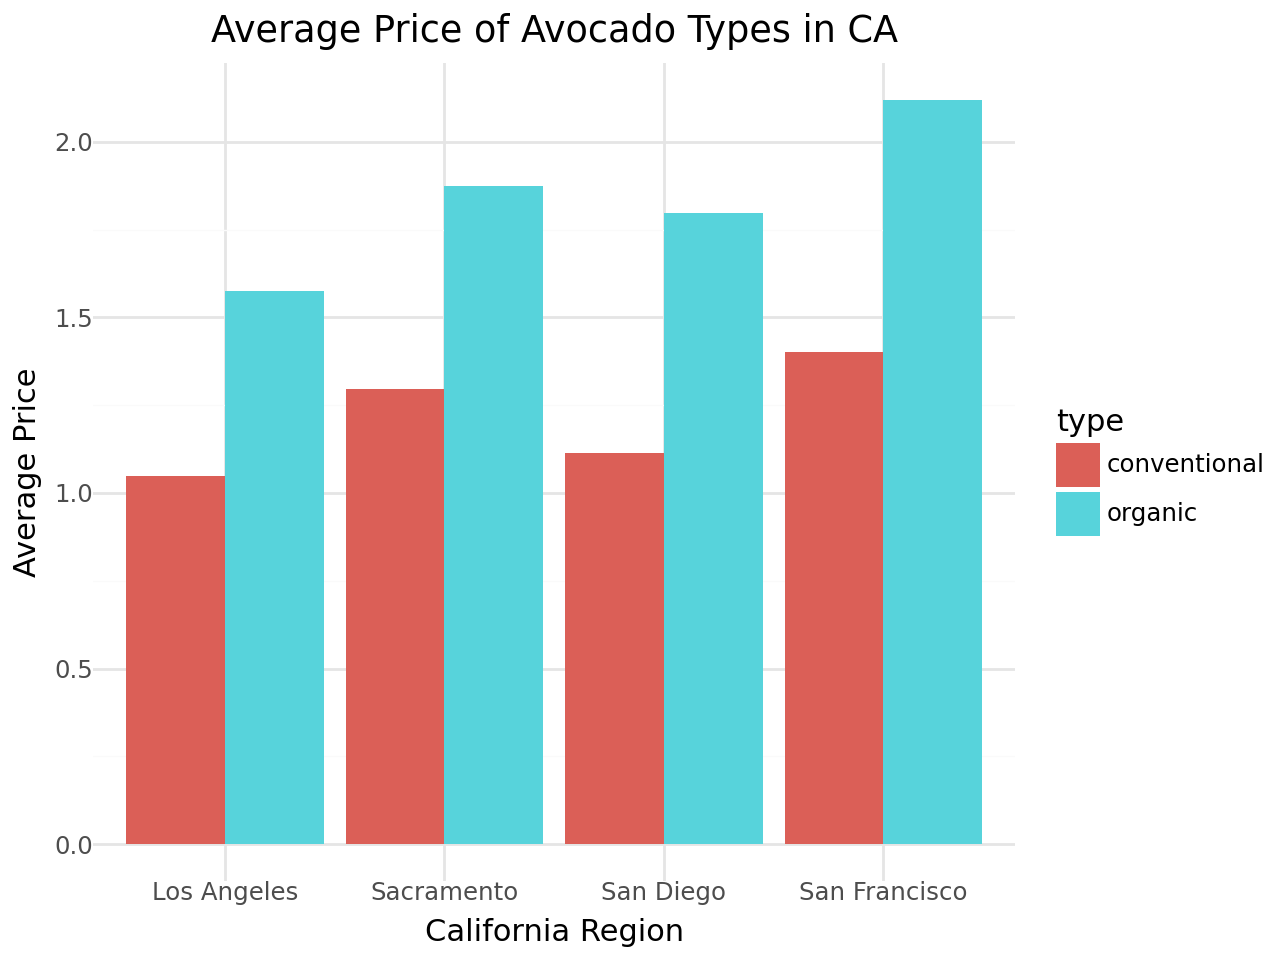

In [30]:
price_melted = price_diff_table.melt(id_vars='geography', value_vars=['organic', 'conventional'],
                                     var_name='type', value_name='average_price') #USed ChatGPT to help 'melt' the dataframe so we can use the type and average price as columns and keep geography as the identifier

ggplot(price_melted, aes(x='geography', y='average_price', fill='type')) \
    + geom_bar(stat='identity', position='dodge') \
    + labs(title='Average Price of Avocado Types in CA',
           x='California Region',
           y='Average Price') \
    + theme_minimal()

8. The following plot shows, for all four California regions, the proportion of the average Hass avocado sales that are small, large, or extra large; conventional vs. organic. Recreate the plot; you do not have to replicate the exact finishing touches - e.g., color, theme - but your plot should resemble the content of this plot.

In [46]:
CA_data = avocados_clean[avocados_clean['geography'].isin(CA_regions)]

CA_data_sizes = CA_data[['small_avocado', 'large_avocado', 'extra_large_avocado', 'type', 'geography']]
#CA_data_sizes


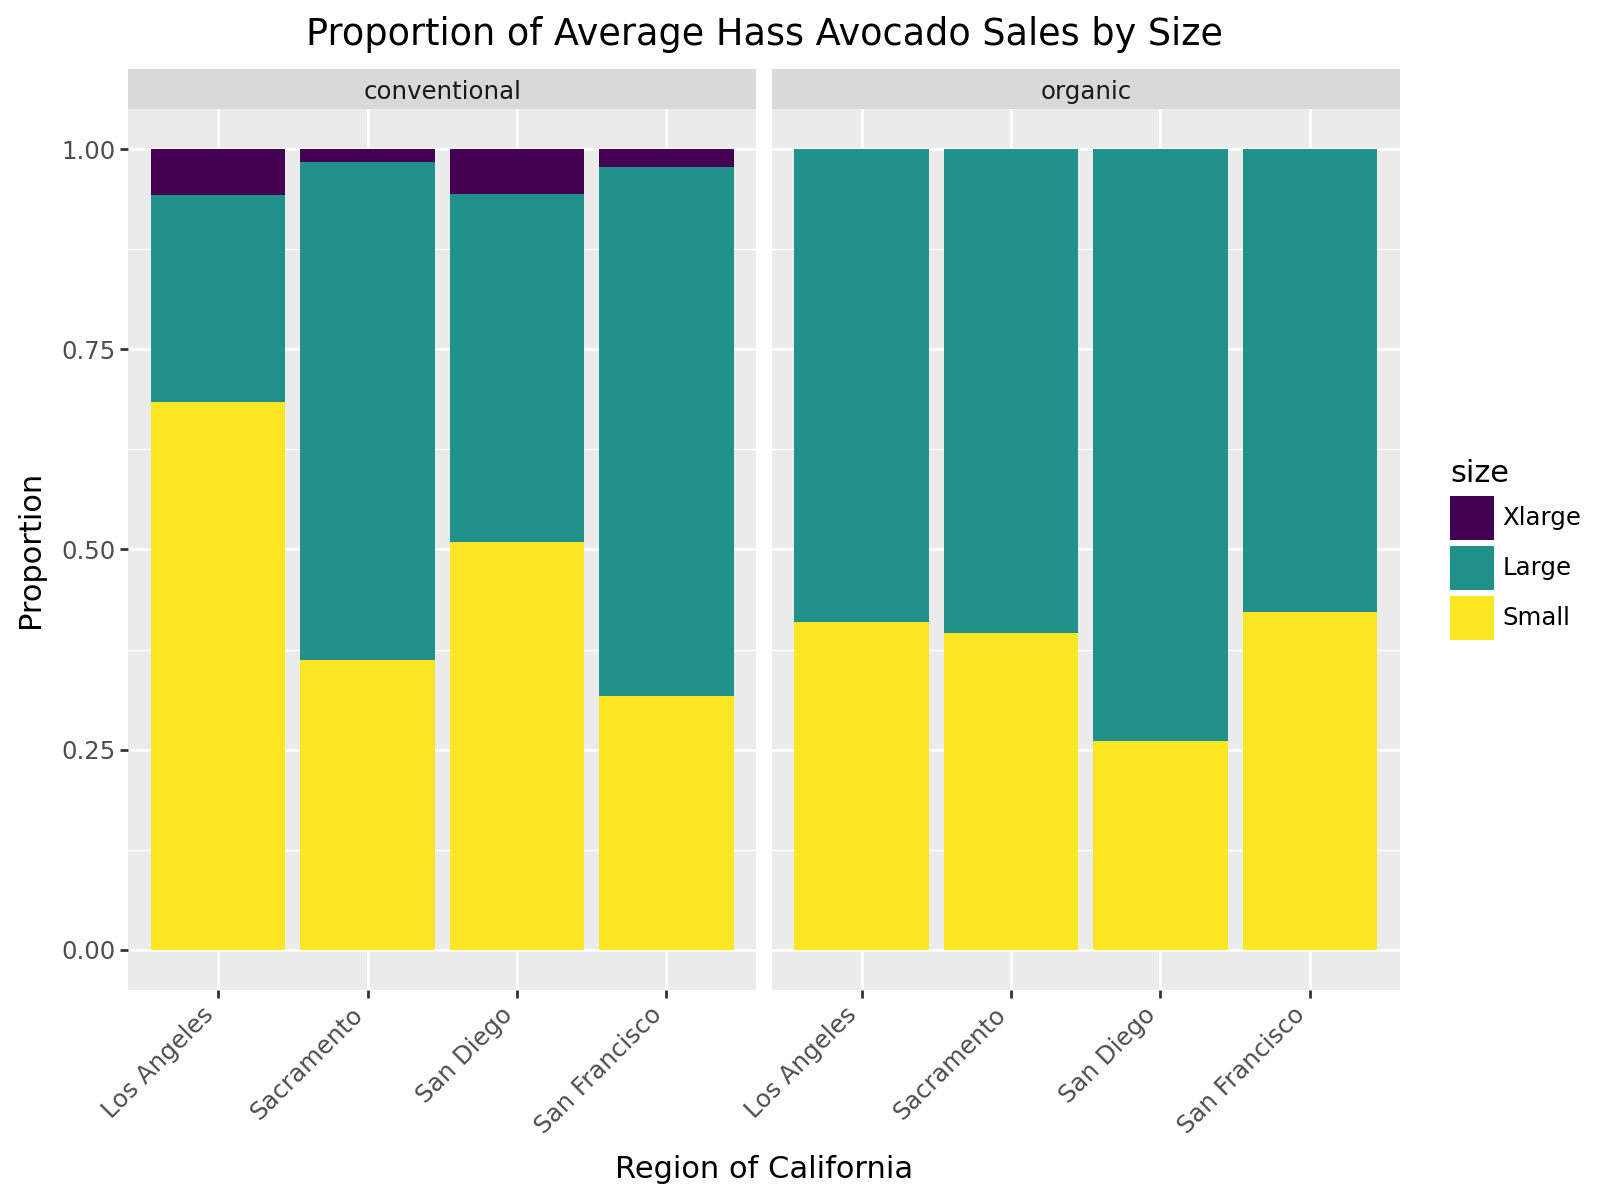

In [47]:
CA_data_sizes

CA_data_sizes_melted = CA_data_sizes.melt(id_vars=['type', 'geography'],
                                          value_vars=['small_avocado', 'large_avocado', 'extra_large_avocado'],
                                          var_name='size', value_name='sales')

CA_data_sizes_melted['size'] = CA_data_sizes_melted['size'].replace({
    'small_avocado': 'Small',
    'large_avocado': 'Large',
    'extra_large_avocado': 'Xlarge'
})

CA_data_sizes_melted['size'] = pd.Categorical(CA_data_sizes_melted['size'],
                                              categories=['Xlarge', 'Large', 'Small'],
                                              ordered=True)

plot = (ggplot(CA_data_sizes_melted, aes(x='geography', y='sales', fill='size'))
        + geom_bar(stat='identity', position='fill')
        + facet_wrap('~type') #ChatGPT provided this line
        + labs(title='Proportion of Average Hass Avocado Sales by Size',
               x='Region of California', y='Proportion')
        + theme(figure_size=(8, 6))
        + theme(axis_text_x=element_text(angle=45, ha='right')) #Used ChatGPT to find how to slant the x-axis labels
       )
plot


Using Outside Data

In [48]:
# Used ChatGPT to help create a realistic dataset
data = {
    "geography": [
        "Los Angeles", "Los Angeles", "Los Angeles", "Los Angeles", "Los Angeles", "Los Angeles",
        "Sacramento", "Sacramento", "Sacramento", "Sacramento", "Sacramento", "Sacramento",
        "San Diego", "San Diego", "San Diego", "San Diego", "San Diego", "San Diego",
        "San Francisco", "San Francisco", "San Francisco", "San Francisco", "San Francisco", "San Francisco"
    ],
    "year": [
        2015, 2016, 2017, 2018, 2019, 2020,
        2015, 2016, 2017, 2018, 2019, 2020,
        2015, 2016, 2017, 2018, 2019, 2020,
        2015, 2016, 2017, 2018, 2019, 2020
    ],
    "average_house_price": [
        600000, 630000, 670000, 720000, 750000, 780000,
        300000, 320000, 350000, 370000, 390000, 410000,
        500000, 530000, 560000, 600000, 630000, 660000,
        900000, 950000, 1000000, 1050000, 1100000, 1150000
    ]
}
house_prices_df_sorted = pd.DataFrame(data)




In [37]:
avocados_agg = CA_data.groupby(['geography', 'year'])['total_volume'].sum().reset_index()
avocados_agg


housing_avocado_table = pd.merge(avocados_agg, house_prices_df_sorted, on=['geography', 'year'], how='left')
housing_avocado_table

,geography,year,total_volume,average_house_price
0,Los Angeles,2015,1.482207e+08,600000
1,Los Angeles,2016,1.631423e+08,630000
2,Los Angeles,2017,1.584812e+08,670000
3,Los Angeles,2018,1.509620e+08,720000
4,Los Angeles,2019,1.631626e+08,750000
5,Los Angeles,2020,1.753817e+08,780000
6,Sacramento,2015,2.198054e+07,300000
7,Sacramento,2016,2.312303e+07,320000
8,Sacramento,2017,2.319243e+07,350000
9,Sacramento,2018,2.662061e+07,370000


/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


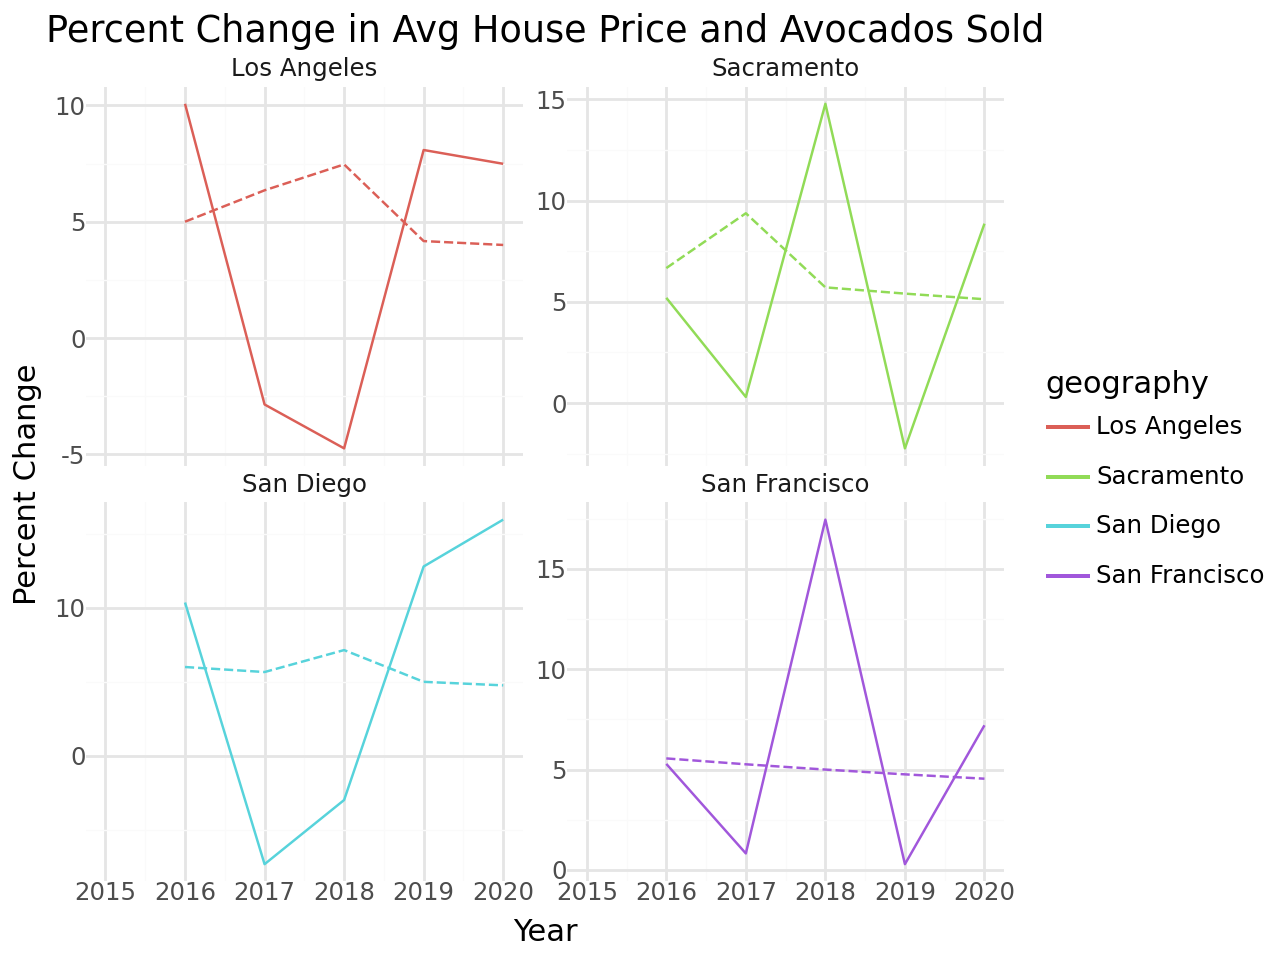

In [49]:
#Used ChatGPT to help find how to get percentage changes over the years
housing_avocado_table['house_price_pct_change'] = housing_avocado_table.groupby('geography')['average_house_price'].pct_change() * 100
housing_avocado_table['total_volume_pct_change'] = housing_avocado_table.groupby('geography')['total_volume'].pct_change() * 100

(ggplot(housing_avocado_table, aes(x='year'))
 + geom_line(aes(y='house_price_pct_change', color='geography'), linetype='dashed')
 + geom_line(aes(y='total_volume_pct_change', color='geography'))
 + facet_wrap('~geography', scales='free_y') #Used ChatGPT to find how to create different plots with their own axises
 + labs(title='Percent Change in Avg House Price and Avocados Sold',
        x='Year',
        y='Percent Change')
 + theme_minimal()
)

Use your new joined data set to make an argument about the relationship between house prices and avocado prices/sales.

Support your argument with a plot. The dotted line represents housing prices and the solid line represents the avocado total volume of sales. We see in the plot above that the percent change in housing prices from year to year does not match with the percent change in acovado total sales from year to year. We see that sometimes the housing price still goes up in the following year even when the avocado sales might decrease. There does not seem to be a very strong relationship between the two.